# Accessing GACS with Python
## Astrophysics Data Queries & Visualizations

In [1]:
# Let's import the libraries we'll be using:
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import os
import getpass
%matplotlib notebook

# Gaia Archive REST URL
gacs_url = 'https://gea.esac.esa.int/tap-server/'
# URL For synchronous queries
gacs_sync_url  = gacs_url + 'tap/sync'
# URL For asynchronous queries
gacs_async_url = gacs_url + 'tap/async' 
# Login URL
gacs_login_url = gacs_url + 'login'
# Delete JOBS URL
gacs_delete_url = gacs_url + 'tap/deletejobs'
# HTTP Session object
session = requests.Session()

In [2]:
# Log into GACS:
# Ask for the password (COSMOS)
password = getpass.getpass('Enter cosmos password:')

# POST the authentication
resp = session.post(gacs_login_url,data = {'username':'edelpozo','password':password})

Enter cosmos password:········


In [3]:
# Function that will write our query results to a csv
def execute_query(query,results_format='csv',delete_job=True):
    
    global gacs_async_url
    global gacs_delete_url
    global session  

    # Submit the Job to Gacs user space
    gacs_query = {'PHASE':'RUN','REQUEST':'doQuery','LANG':'ADQL','FORMAT':results_format,'QUERY':query}
    start = time.time()
    resp = session.post(gacs_async_url,params=gacs_query)   
    if resp.status_code != 200:
        raise Exception('Error launching the job ... ', query , resp.text)       
    url_job = resp.url    
    print('Submitted job to GACS: Job URL=' + url_job)
        
    # Poll the server till the Query is finished
    while True:       
        resp = session.get(url_job)       
        if resp.status_code != 200:
            raise Exception('Error checking job status ... ', url_job , resp.text)         
        if resp.text.find('COMPLETED') >= 0:
            break;
        if resp.text.find('ERROR') >= 0:
            raise Exception('Error in the query exitting ... ', url_job , resp.text)   
        time.sleep(0.2)   
    
    # Get results
    results = session.get(url_job + '/results/result')
    if results.status_code != 200:
        raise Exception('Error launching the job ... ', query , results.text) 
        
    stop = time.time()
    print('Query time: ' + str(stop-start) + ' seconds')
    
    # Delete the Job from the Gaia Archive
    if delete_job:
        job_id = url_job.split('/')[-1]
        session.post(gacs_delete_url,data ={'JOB_IDS':job_id})
        if resp.status_code != 200:
            raise Exception('Error deleting the job ... ', job_id , resp.text) 
    
    return results

# TEST the function
resp = execute_query('SELECT TOP 5 source_id,ra,dec FROM gaiadr1.gaia_source')

Submitted job to GACS: Job URL=https://gea.esac.esa.int/tap-server/tap/async/1530209680501O
Query time: 2.856271982192993 seconds


### Create Hipparcos and Gaia DR1 B-V HR diagrams

The HR (Hertzsprung Russell) diagram relates a star's temperature to its brightness. 

In [4]:
# Define the query: Getting the parallax from tgas and hipparcos catalogue, apparent magnitude 
# and hipparcos b_v parameter.
select = 'SELECT gaia.parallax,hip.plx,gaia.phot_g_mean_mag,hip.b_v '
tables = ' FROM gaiadr1.tgas_source as gaia INNER JOIN public.hipparcos_newreduction as hip on gaia.hip = hip.hip'
where = (' where gaia.parallax/gaia.parallax_error >= 5 and '
         'hip.plx/hip.e_plx >= 5 and '
         'hip.e_b_v > 0.0 and hip.e_b_v <= 0.05 and '
         '2.5/log(10)*gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux <= 0.05')
gacs_query = select + tables + where

# Run the query
resp = execute_query(gacs_query)

# Load the information from the request results in CSV
gaiaplx, hipplx, ap_gmag, hip_bv = np.loadtxt(resp.text.split('\n'),skiprows=1,delimiter=',',unpack=True)

Submitted job to GACS: Job URL=https://gea.esac.esa.int/tap-server/tap/async/1530210145005O
Query time: 15.427199125289917 seconds


In [5]:
# Function for computing the absolute magnitude
def abs_mag(parallax,apparent_mag):
    return apparent_mag+5*np.log10(np.abs(parallax))-10

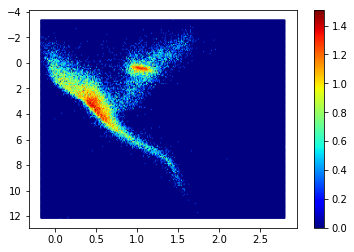

In [14]:
# Compute the absolute magnitude for Gaia
abs_mag_gaia = abs_mag(gaiaplx,ap_gmag)

# Plot the HR diagram for these stars
plt.hexbin(hip_bv, abs_mag_gaia, gridsize = 300,cmap=cm.jet, bins='log')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

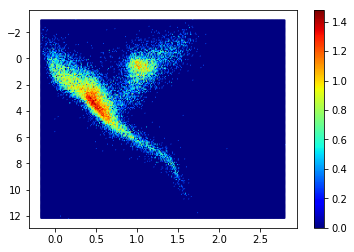

In [7]:
# Compute the absolute magnitude for Hipparcos
abs_mag_hip = abs_mag(hipplx,ap_gmag)

# Plot the 
plt.hexbin(hip_bv, abs_mag_hip, gridsize = 300,cmap=cm.jet, bins='log')
#plt.scatter(hip_bv,abs_mag_gaia, c=heatmap , s=10, cmap=cm.hot , lw=0)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

C:\Users\Rigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


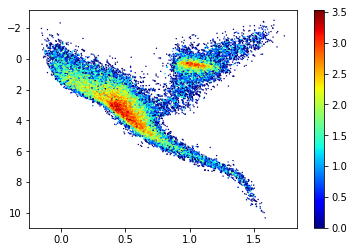

In [8]:
# Let's join the Gaia and Hipparcos stars
hist, xedges, yedges = np.histogram2d(hip_bv,abs_mag_gaia, bins=300)

xidx = np.clip(np.digitize(hip_bv, xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(abs_mag_gaia, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]

plt.gca().invert_yaxis()
plt.scatter(hip_bv,abs_mag_gaia, c=np.log(c), s=2,cmap=cm.jet, lw=0)
plt.colorbar()
plt.show()

## Create a Proper Motion diagram around the LMC
### With TGAS and Hipparcos

In [9]:
select = "SELECT gaia.pmra,gaia.pmdec,gaia.phot_g_mean_mag,gaia.ra,gaia.dec"
tables = " FROM gaiadr1.tgas_source as gaia INNER JOIN public.hipparcos_newreduction as hip on gaia.hip = hip.hip"
where  = (" WHERE 1=CONTAINS(POINT('ICRS',gaia.l,gaia.b), "
          "CIRCLE('ICRS',-80.33880679040755,-33.99943305252677,3.1))"
          " AND gaia.source_id IN "
          "(4655349652394811136,4655510043652327552,4655460771785226880,4661769941306044416,"
          "4661720532007512320,4655136518933846784,4655158131209278464,4662293892954562048,"
          "4654621500815442816,4655036841335115392,4661920986713556352,4661472145451256576,"
          "4662061311885050624,4651629489160555392,4658269336800428672,4658204053297963392,"
          "4658137739001073280,4660601607121368704,4660444926713007872,4658486455992620416,"
          "4660175580731856128,4660124762671796096,4660246224352015232,4657280635327480832,"
          "4657700408260606592,4657627943562907520,4657722879521554176,4659188769038018816,"
          "4659091084305723392)")

gacs_query = select + tables + where
resp = execute_query(gacs_query)

# Load the information from the request results 
pm_ra,pm_dec,gmag, ra, dec = np.loadtxt(resp.text.split('\n'),skiprows=1,delimiter=',',unpack=True)

Submitted job to GACS: Job URL=https://gea.esac.esa.int/tap-server/tap/async/1530210446723O
Query time: 2.772231101989746 seconds


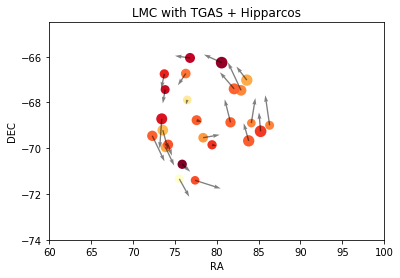

In [10]:
# GMAG ... 
area = np.linspace(np.min(gmag), np.max(gmag), 10)

# Show the scatter plot
plt.scatter(ra,dec, c=gmag,s=area**2, cmap=cm.YlOrRd, lw=0)
plt.title('LMC with TGAS + Hipparcos')
plt.xlabel('RA')
plt.ylabel('DEC')
pm_ra = pm_ra - np.mean(pm_ra)
pm_dec = pm_dec - np.mean(pm_dec)
# Plot the arrows ...
plt.quiver(ra,dec,pm_ra,pm_dec,width=0.004,alpha=0.5,color='Black')

plt.gca().invert_xaxis()
plt.gca().set_xlim([60.0,100.0])
plt.gca().set_ylim([-74,-64.5])
plt.show()

### Proper motion diagram - Pleiades

Submitted job to GACS: Job URL=https://gea.esac.esa.int/tap-server/tap/async/1530210491521O
Query time: 2.737733840942383 seconds


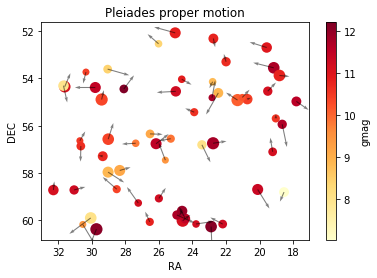

In [11]:
pleiades_center_dec = 56.75
pleiades_center_ra  = 24.12
select = "SELECT gaia.pmra,gaia.pmdec,gaia.phot_g_mean_mag,gaia.ra,gaia.dec"
tables = " FROM gaiadr1.tgas_source as gaia"
where  = (" WHERE 1=CONTAINS(POINT('ICRS',gaia.ra,gaia.dec), "
          "CIRCLE('ICRS'," + str(pleiades_center_ra) + "," + str(pleiades_center_dec) + ",5))"
          " and sqrt(power(gaia.pmra-20.5,2)+power(gaia.pmdec+45.5,2)) < 20.0")

gacs_query = select + tables + where
resp = execute_query(gacs_query)

# Load the information from the request results 
pm_ra,pm_dec,gmag, ra, dec = np.loadtxt(resp.text.split('\n'),skiprows=1,delimiter=',',unpack=True)

area = np.linspace(np.min(gmag), np.max(gmag), 10)

val = plt.scatter(ra,dec, c=gmag,s=area**2, cmap=cm.YlOrRd, lw=0)
plt.title('Pleiades proper motion')
plt.xlabel('RA')
plt.ylabel('DEC')
cbar = plt.colorbar(val)
cbar.ax.set_ylabel('gmag')
pm_ra = pm_ra - np.mean(pm_ra)
pm_dec = pm_dec - np.mean(pm_dec)
plt.quiver(ra,dec,pm_ra,pm_dec,width=0.004,alpha=0.5,color='Black')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

### Proper Motion Diagram - Barnard's Star

Submitted job to GACS: Job URL=https://gea.esac.esa.int/tap-server/tap/async/1530210534122O
Query time: 2.9883103370666504 seconds


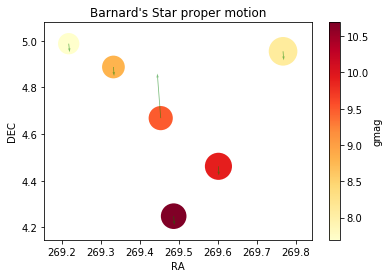

In [12]:
barnard_center_dec = 4.66828815
barnard_center_ra  = 269.45402305
select = "SELECT hip.pmra,hip.pmde,hip.hpmag,hip.ra,hip.de"
tables = " FROM public.hipparcos as hip"
where  = (" WHERE 1=CONTAINS(POINT('ICRS',hip.ra,hip.de), "
          "CIRCLE('ICRS'," + str(barnard_center_ra) + "," + str(barnard_center_dec) + ",0.466666))")


gacs_query = select + tables + where
resp = execute_query(gacs_query)

# Load the information from the request results 
pm_ra,pm_dec,gmag, ra, dec = np.loadtxt(resp.text.split('\n'),skiprows=1,delimiter=',',unpack=True)

area = np.linspace(np.min(gmag), np.max(gmag), 10)

val = plt.scatter(ra,dec, c=gmag,s=area**3, cmap=cm.YlOrRd, lw=0)
plt.title("Barnard's Star proper motion")
plt.xlabel('RA')
plt.ylabel('DEC')
cbar = plt.colorbar(val)
cbar.ax.set_ylabel('gmag')
pm_ra = pm_ra - np.mean(pm_ra)
pm_dec = pm_dec - np.mean(pm_dec)
plt.quiver(ra,dec,pm_ra,pm_dec,width=0.003,alpha=0.5,color='Green')
plt.show()